In [7]:
from sqlalchemy import *
import numpy as np
import pylab as plt
import pandas as pd
from scipy.ndimage.interpolation import shift
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.optimize import newton
#import peakutils
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
%matplotlib inline
import plotly
plotly.offline.init_notebook_mode()
import plotly.plotly as py
from plotly.offline import iplot,plot
import plotly.graph_objs as go
import time
plotly.offline.init_notebook_mode(connected=True)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [2]:
start_time = time.time()
engine = create_engine('sqlite+pysqlite:///../data/SQL/10C/85_8.db')
ADCdf = pd.io.sql.read_sql("SELECT * FROM ADC", engine)
end_time = time.time()
print end_time-start_time

engine = create_engine('sqlite+pysqlite:///../data/SQL/10C/ProtoMap.db')
ProtoMapdf = pd.io.sql.read_sql("SELECT * FROM ProtoMap", engine)
print ProtoMapdf.head()


139.404493093
   PadNum        PadName     PadX      PadY  BinNum
0       0  sector_center  0.00000  0.000000     257
1       1      sector1_0  1.30108  0.947523       1
2       2      sector2_0  2.18496  1.831410       2
3       3      sector1_1  2.71529  2.361740       3
4       4      sector2_1  3.59917  3.245620       4


In [3]:
def Process(Event):
    thre = 50 ## thre for minimum for the maximum in a pad to be considered
    
    #mesh = Event.iloc[:,3:][Event.iloc[:,3:]>10].sum(axis=0)
    tmp = Event[Event['PadNum']>-1]
    #median = tmp.iloc[:,3:].median(axis=0)
    #tmp = (tmp.iloc[:,3:]-median)
    tmp = tmp[tmp.iloc[:,50:-50].max(axis=1)>thre]
    return tmp.sum(axis=0)
    
    
start_time = time.time()
mesh_df = ADCdf.groupby('EventID').apply(Process)
end_time = time.time()
print end_time-start_time

6.86229801178


In [4]:
ADCdf.head()

,ID,EventID,PadNum,t0,t1,t2,t3,t4,t5,t6,...,t502,t503,t504,t505,t506,t507,t508,t509,t510,t511
0,1,0,97,-16.200001,-0.2,-1.2,1.8,0.8,-4.2,3.8,...,-3.2,-3.2,-5.2,-5.2,-5.2,-8.2,-6.2,-8.2,-1.2,-5.2
1,2,0,158,-8.300000,-1.3,-1.3,0.7,-1.3,-4.3,6.7,...,1.7,2.7,3.7,3.7,4.7,-1.3,-1.3,1.7,7.7,5.7
2,3,0,161,-8.500000,-0.5,2.5,4.5,1.5,-8.5,2.5,...,-1.5,-1.5,1.5,-0.5,2.5,1.5,4.5,4.5,9.5,3.5
3,4,0,95,-7.600000,-5.6,-4.6,0.4,1.4,0.4,4.4,...,-0.6,1.4,-1.6,3.4,1.4,0.4,-2.6,-2.6,8.4,4.4
4,5,0,98,-5.800000,-0.8,-0.8,3.2,0.2,-4.8,1.2,...,2.2,-1.8,0.2,3.2,3.2,3.2,1.2,2.2,6.2,4.2


/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)



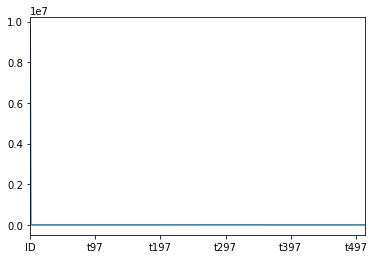

In [8]:
EID=600
t1 = ADCdf[ADCdf['EventID']==EID].drop(['ID'],axis=1)
n1 = [_ for _ in t1.columns if _[0]=='t']
n2 = [_ for _ in t1.columns if _[0]!='t']
t2 = pd.melt(t1,id_vars=n2,value_vars=n1)

t2.columns = ['EventID','PadNum','time','charge']
t2['time'] = t2.time.str.extract('t(\d+)').astype(int)
t3 = pd.merge(t2,ProtoMapdf,on='PadNum').drop(['PadName','BinNum'],axis=1)
t4 = t3[t3['charge']>50]

trace1 = go.Scatter3d(
    x=t4['PadX'],
    y=t4['PadY'],
    z=t4['time'],#*80/1000.0*2.459,
    mode='markers',
    marker=dict(
        size=3,
        color='b',                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.5
    ), 
  
)

layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        nticks=4, range = [-100,100],),
                    yaxis = dict(
                        nticks=4, range = [-100,100],),
                    zaxis = dict(
                        nticks=4, range = [0,500],),),

                  )
fig = go.Figure(data=[trace1], layout=layout)


iplot(fig, filename='basic histogram')
mesh_df.ix[EID].plot()

In [6]:

start_time = time.time()
n1 = [_ for _ in ADCdf.columns if _[0]=='t']
n2 = [_ for _ in ADCdf.columns if _[0]!='t']
t2 = pd.melt(ADCdf.iloc[:],id_vars=n2,value_vars=n1).drop(['ID'],axis=1)
t2.columns = ['EventID','PadNum','time','charge']
t2['time'] = t2.time.str.extract('t(\d+)').astype(int)
print time.time() - start_time

/afs/crc.nd.edu/user/j/jlai1/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)



441.772917032


In [8]:
#pd.merge(t2.iloc[:],ProtoMapdf,on='PadNum')

t3 = t2[t2['charge']>20]

def Process(df):
    '''
    filter out noise and long tail
    '''
    Thre = 0.1
    Max = df['charge'].max(axis=0)
    return df[df['charge']>0.03*Max]
    
t4 = t3.groupby('EventID').apply(Process).reset_index(drop=True)
t5 = pd.merge(t4,ProtoMapdf,on='PadNum')[['EventID','time','PadX','PadY','charge']]

In [10]:
tmp = t5[t5['EventID']==1]
trace1 = go.Scatter3d( x=tmp['PadX'],y=tmp['PadY'],z=tmp['time'], mode='markers',
    marker=dict(size=3, color='b', colorscale='Viridis', opacity=0.5), 
)

layout = go.Layout(scene = dict(
                    xaxis = dict(nticks=4, range = [-100,100],),
                    yaxis = dict(nticks=4, range = [-100,100],),
                    zaxis = dict(nticks=4, range = [0,500],),))
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

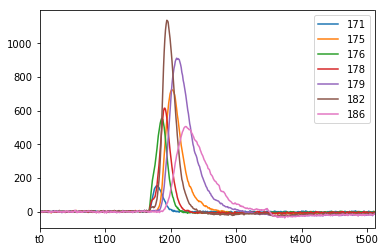

In [11]:
ADCdf[(ADCdf['EventID']==0)&(ADCdf['PadNum'].isin(range(3,10)))].iloc[:,3:].T.plot()
#plt.ylim([-100,200])

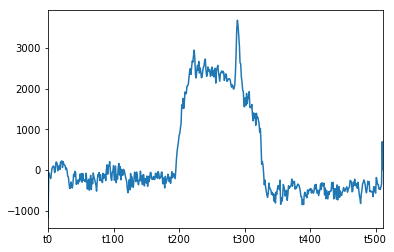

In [21]:
ADCdf[(ADCdf['EventID']==1)].iloc[:,3:].sum(axis=0).plot()


In [12]:
tmp = t5[t5['EventID']==1]
trace1 = go.Scatter( x=(tmp['PadX'].pow(2)+tmp['PadY'].pow(2)).pow(0.5),y=tmp['time'], mode='markers',
    marker=dict(size=3, color='b', colorscale='Viridis', opacity=1), 
)

layout = go.Layout(scene = dict(
                    xaxis = dict(nticks=4, range = [0,200],),
                    yaxis = dict(nticks=4, range = [0,500],),))
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

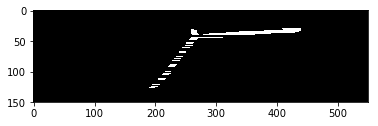

In [12]:
tmpdf = t5[t5['EventID']==15]

image = np.zeros([150,550])

image[((np.sqrt(tmpdf['PadX']*tmpdf['PadX']+tmpdf['PadY']*tmpdf['PadY'])).values+30).astype(np.int),
      (tmpdf['time'].values).astype(np.int)] =255

plt.imshow(image, cmap='gray')
#element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
#eroded = cv2.erode(image,element)


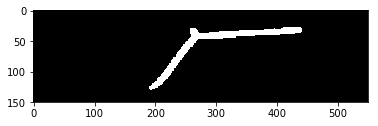

In [13]:
blur = cv2.blur(image.astype(np.uint8),(5,5))
ret,im = cv2.threshold(blur,20,255,cv2.THRESH_BINARY)
plt.imshow(im, cmap='gray')

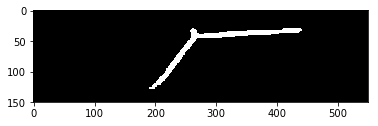

In [14]:
kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(im,kernel,iterations =1)
plt.imshow(erosion, cmap='gray')

1


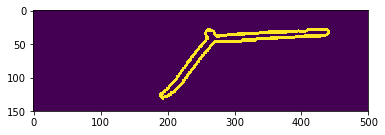

In [15]:
im1, contours, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
imm = np.zeros([150,500])
print len(contours)
cv2.drawContours(imm, contours, 0, (255,255,0), 3)
plt.imshow(imm)

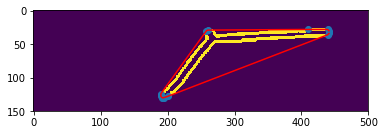

In [16]:
hull= cv2.convexHull(contours[0])
#plt.plot(hull[:,0,:])
plt.imshow(imm)
plt.plot(hull[:,0,:][:,0],hull[:,0,:][:,1],c='r')
plt.scatter(hull[:,0,:][:,0],hull[:,0,:][:,1])

In [17]:
cv2.minAreaTri(cnt)

AttributeError: 'module' object has no attribute 'minAreaTri'

In [ ]:

kernel = np.ones((2,2),np.uint8)
erosion = cv2.erode(image,kernel,iterations = 1)
plt.imshow(erosion)
#plt.ylim([0,50])

In [ ]:
#img_grey = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2GRAY)
th3 = cv2.adaptiveThreshold(255-image.astype(np.uint8),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

In [ ]:
image.astype(np.uint8)

In [ ]:
plt.imshow(th3)

In [ ]:
ret,th1 = cv2.threshold(255-image.astype(np.uint8),127,255,cv2.THRESH_BINARY)


In [ ]:
plt.imshow(th1)

In [ ]:
th2 = cv2.adaptiveThreshold(image.astype(np.uint8),255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)

In [ ]:
im, contours, hierarchy = cv2.findContours(th3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
cv2.drawContours(im, contours, -1, (0,255,0), 3)
plt.imshow(im)

In [ ]:
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(255-im,kernel,iterations = 1)
plt.imshow(erosion, alpha=0.6, cmap='gray')
plt.figure()
plt.imshow(image.astype(np.uint8),alpha=0.5, cmap='gray')
plt.figure()
plt.imshow(im,alpha=0.5, cmap='gray')

In [ ]:
im1, contours, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(im1)


In [ ]:
contours[0].shape

In [ ]:
contours[1].shape

In [ ]:
imm = np.zeros([150,500])

cv2.drawContours(imm, [contours[1]], 0, (255,255,0), 3)
plt.imshow(imm)

In [ ]:
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(img,kernel,iterations = 1)